This notebook makes the 1e1p detvar matrices (to use independently), text files (to send to Ran to get the combined version), and some plots for checking the output

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
from numpy import mean
from math import sqrt,acos,cos,sin,pi,exp,log,isnan,atan2
from numpy import asarray
from matplotlib import gridspec
from scipy import stats,signal
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from textwrap import wrap
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

import os
from PlottingScripts import distVar

from IPython.core.display import display, HTML

In [5]:
datafolder = '/home/kmason/fullosc/NicksCode/1e1pdata/'
auxfolder = datafolder+ 'aux/'
# tag the pickles came from, used for saving
tag = '3March2021_vA_fullLowE_withPi0Sample_newShowerCalib'

verbose = False
# tag for saving the outputs
savetag = '23Feb2022'
modelist = ['avgscore']
sigcutlist = [0.95]

# make directory to save files
basefolder = '/home/kmason/fullosc/NicksCode/1L1PSelection/1e1pBDT/CovMatrices/DetVar/'+tag+'/'+savetag+'/'
if not os.path.exists(basefolder):
    os.makedirs(basefolder)
plotfolder = basefolder+'PlotDumps/'
covfolder = basefolder+'covMatrix/'
histfolder = basefolder+'1Dhists/'
if not os.path.exists(plotfolder):
    os.makedirs(plotfolder)
if not os.path.exists(covfolder):
    os.makedirs(covfolder)
if not os.path.exists(histfolder):
    os.makedirs(histfolder)
covtag = 'frac_covar_run3_%s'%tag



RSE  = ['run','subrun','event']

def decode_df(df):
    cols = []
    for col in df:
        cols.append(col.decode("utf-8"))
        try: 
            df[col].apply(lambda x: x.decode("utf-8"))
        except:
            pass
    df.columns = cols
    return df

# RUN 3 

In [22]:
f_scaleslist = []
s_detsyslist = []
names = ['WireModX','WireModYZ','recomb2','LYDown','LYAtt','LYRayleigh','SCE','WireModThetaYZ','WireModThetaXZ']

for name in names:
    s_detsyslist.append(name)

#df_cv = pd.read_parquet('../../data/pickles/detsys_CV_run3_nodupesMay1.parquet')
#scaleCV = 9.65858292241e+19 

a_df_sys = {}

names = {}

for sigcut in sigcutlist:
    for mode in modelist: 
        key = tuple((sigcut,mode))
        a_df_sys[key] = {}
        names[key] = {}
        print('#'*10,key,'#'*10)
        
        for run in ['run1','run3']:

            a_df_sys[key][run] = {}
            names[key][run] = []

            RSE = ['run','subrun','event']
            sRSE = ['sample'] + RSE

            for sys in s_detsyslist:
 
                if True:
                    try: 
                        df_sys = decode_df(pd.read_parquet('%sdetvar/overlay_%s_%s_cutMode%i.parquet'%(auxfolder,sys,run,cutMode)))
                    except:
                        continue
                else:
                    try:
                        df_sys = decode_df(pd.read_parquet('%sdetvar/%s_%s_cutMode%s.parquet'%(auxfolder,sys,run,cutMode)))
                    except:
#                         print('%s/overlay_%s_%s_cutMode%i.parquet'%(auxfolder,sys,run,cutMode))
                        continue
                names[key][run].append(sys)
                a_df_sys[key][run][sys] = df_sys.copy()
                print(run,sys,"total %d, cv = %d dv = %d"%((np.sum(df_sys['bdtweight']>0),
                                                           (np.sum((df_sys.query("isCV==True"))['bdtweight']>0)),
                                                           (np.sum((df_sys.query("isCV==False"))['bdtweight']>0)))))
for sigcut in sigcutlist:
    for mode in modelist: 
        key = tuple((sigcut,mode))
        for run in ['run1','run3']:
            print(key,run)
            for k,df in (a_df_sys[key][run]).items():
                print(k,np.sum(df['bdtweight']>0))
                
                

########## (0.95, 'avgscore') ##########
run1 LYDown total 9, cv = 4 dv = 5
run1 LYRayleigh total 11, cv = 4 dv = 7
run1 SCE total 9, cv = 4 dv = 5
run3 WireModX total 11, cv = 4 dv = 7
run3 WireModYZ total 9, cv = 4 dv = 5
run3 LYDown total 7, cv = 4 dv = 3
run3 LYRayleigh total 9, cv = 4 dv = 5
run3 SCE total 8, cv = 4 dv = 4
run3 WireModThetaYZ total 9, cv = 4 dv = 5
run3 WireModThetaXZ total 13, cv = 4 dv = 9
(0.95, 'avgscore') run1
LYDown 9
LYRayleigh 11
SCE 9
(0.95, 'avgscore') run3
WireModX 11
WireModYZ 9
LYDown 7
LYRayleigh 9
SCE 8
WireModThetaYZ 9
WireModThetaXZ 13


In [23]:
# Make big list of variables with their accompanying ranges so we can just dump a buttload of plots
#varlistSel = {}
var_names = ['Enu_1e1p','Eta','PT_1e1p','AlphaT_1e1p',
              'SphB_1e1p','PzEnu_1e1p','ChargeNearTrunk',
              'Q0_1e1p','Q3_1e1p','Thetas','Phis','PTRat_1e1p',
              'Proton_ThetaReco','Proton_PhiReco',
              'MinShrFrac','MaxShrFrac',
              'BjXB_1e1p','BjYB_1e1p','Proton_Edep',
              'Electron_Edep',
              'Lepton_ThetaReco','Lepton_PhiReco',
              'OpenAng','Xreco','Yreco','Zreco',
              'sigprob','MPIDY_muon',
              'MPIDY_proton','MPIDY_eminus','shower_fraction',
              'Shower_Consistency',
              'EnuQE_lepton','EnuQE_proton',
              'Proton_TrackLength','Lepton_TrackLength','EnuTrue']

var_labels = [r'$E_\nu^{Range}$ [MeV]',r'$\eta$',r'Event $p_T$ [MeV]',r'$\alpha_T$',
              'QE Consistency',r'$p_z - E_\nu$ [MeV]','Charge Near Trunk',
              r'$Q_0$ [MeV]',r'$Q_3$ [MeV]',r'$\theta_e + \theta_p$',r'$|\phi_e - \phi_p|$',r'Event $p_T/p$',
              r'$\theta_p$',r'$\phi_p$',
              'Minimum Shower Fraction','Maximum Shower Fraction',
              'Bjorken X (Nucleon Rest Frame)','Bjorken Y (Nucleon Rest Frame)',r'$E_p$ [MeV]',
              r'$E_e$ [MeV]',
              r'$\theta_e$',r'$\phi_e$',
              'Opening Angle',r'$X_{reco}$',r'$Y_{reco}$','$Z_{reco}',
              '1e1p BDT Score','Muon MPID Score (Y plane)',
              'Proton MPID Score (Y plane)','Electron MPID Score (Y plane)','Shower Fraction',
              'Shower Energy Consistency',
              r'$E_\nu^{Q-e}$',r'$E_\nu^{QE-p}$',
              'Proton Track Length [cm]','Lepton Track Length [cm]','EnuTrue']

ranges = [ (200,2400),(0,0.6),(0,800),(0,np.pi),(0,5000),(-800,300),
           (0,800),(100,700),(0,1400),(0,2*np.pi),(0,2*np.pi),
           (0,1),(0,np.pi),(-np.pi,np.pi),(-1,1),(-1,1),(0,3),
           (0,1),(60,500),(35,1200),(0,np.pi),
           (-np.pi,np.pi),(0,np.pi),(0,256),(-117,117),(0,1036),
           (0,1),(0,1),(0,1),(0,1),(0,3),(0,5),
           (0,1200),(0,1200),(0,100),(0,200),(0,1200)]

ranges[27] = (0.95,1) #bdt ranges

    
varListSel = {}

for name,label,rnge in zip(var_names,var_labels,ranges):   
    varListSel[name] = distVar(name,rnge,name,covfolder+'/'+covtag+'__'+name+'.txt')

# Build Covariance Matrices!

In [24]:
#just need CV cut
s_cuts = 'isCV ==False'
s_cuts_cv = 'isCV ==True' 

# do we want any extra cuts?
s_cuts += ' and Enu_1e1p < 2400'
s_cuts_cv += ' and Enu_1e1p < 2400'



In [25]:
#Bring in the required modules
from scipy import *
from scipy import signal
import matplotlib
import numpy as np
from matplotlib import pyplot as plt
from scipy.fftpack import fft, fftfreq
from scipy.signal import lfilter
import scipy.signal
from scipy.optimize import leastsq
import pandas as pd
import scipy.stats as stats
import matplotlib.mlab as mlab
from scipy.stats import norm
import sklearn
from sklearn.neighbors import KernelDensity
print('The scikit-learn version is {}.'.format(sklearn.__version__))
#from sklearn.utils.fixes import parse_version
from random import random




def smooth(cv_list,dv_list,cv_weights,dv_weights,xmin,xmax,run,nbin=20):
    extraBinUp=4
    extraBinDown=2
    binsE=[200,300,400,500,600,700,800,900,1000,1100,1200,1600,2400]
#     binsE=[200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000,2100,2200,2300,2400]
    nbin=len(binsE)-1
    print("nbin",nbin)
    #----------------------------------------------------------------
    # This section is the CV
    binSize = int(100)
    nbin_in = nbin+extraBinDown+extraBinUp
    xmax_in=binsE[-1]+extraBinUp*binSize
    xmin_in=binsE[0]-extraBinDown*binSize
    ext_bin=10
    cv = np.array(cv_list)
    dv = np.array(dv_list)
    cvw = np.array(cv_weights)+0.00000001
    print(nbin, len(cvw))
    dvw = np.array(dv_weights)+0.00000001
    #for x,y in zip(cv,cvw):
    #    print(x,y)
    # throw away the data points outside of the hist limits to fake the real data
    #    mask1 = np.logical_and(cv >= xmin, cv <= xmax)
    #    cv = cv[mask1]
    cv_hist, binedges = np.histogram(cv, weights=cvw, bins = binsE)
    cv_hist[-1]*= 1.0/8.0
    cv_hist[-2]*= 1.0/4.0
    cv_var, binedges = np.histogram(cv, weights=cvw**2, bins = binsE)
    cv_var[-1]*= 1.0/8.0
    cv_var[-2]*= 1.0/4.0
    cv_hist= cv_hist+0.000000001 # assure no zero bins    
    #-------------------------------------------------------------------------------
    # look for spikes at edges and remove them.  Smoothing cannot handle these.
    # flags for bin drops
    drop0=False
    dropn=False
    # throw away the first bin if needed
    # do this if the change is more than 80%
    #print('cv[0] =  %f    cv[1] = %f  rat = %f'%(cv[0],cv[1],cv[0]/(cv[0]+cv[1])))
#     if ((cv_hist[0]/(cv_hist[0]+cv_hist[1]))>0.80):
#         drop0=True
#     if ((cv_hist[nbin-1]/(cv_hist[nbin-2]+cv_hist[nbin-1]))>0.80):
#         dropn=True
    # throw away the firstand/or last bin if needed
    if (drop0):    
        mask1 = np.logical_and(cv >= binedges[1], cv <= xmax)
        cv = cv[mask1]
        print('drop0_cv')
    if (dropn):
        mask1 = np.logical_and(cv >= xmin, cv <=  binedges[nbin-1])
        cv = cv[mask1]
        print('dropn_cv')
    #-------------------------------------------------------------------------------
    # CV smoothing, calculate the bandwidth for use throughout
    # calculate Sheather/Jones bandwidth
    bwid=0.55*0.9*(xmax-xmin)*((sum(cv_hist))**(-1./7))
    #print('bwid = %f'%bwid)
    # This smoothing library wants 2d so pad it out
    cv2d=cv [:, np.newaxis]
    myrange = (lambda edges: (edges[:-1] + edges[1:])/2.0)(np.linspace(xmin_in,xmax_in,(ext_bin*nbin_in)+1))
#    print(myrange)
    range2d=myrange [:, np.newaxis]
    #    #print(myrange)
    #----------------------------------------------------------------
    # This section is the detvar
    #
    # Create Fake data np.histograms,aiming for about 4000 events in the np.histogram
    #
    # This smoothing library wants 2d so pad it out
    dv_hist, binedges = np.histogram(dv, weights=dvw, bins = binsE)
    dv_hist[-1]*= 1.0/8.0
    dv_hist[-2]*= 1.0/4.0
    dv_var, binedges = np.histogram(dv, weights=dvw**2, bins = binsE)
    dv_var[-1]*= 1.0/8.0
    dv_var[-2]*= 1.0/4.0
    dv_hist= dv_hist+0.000000001 # assure no zero bins    
    # throw away the firstand/or last bin if needed
    if (drop0):    
        mask1 = np.logical_and(dv >= binedges[1], dv <= xmax)
        #print('dv length = %d and dv_w length =%d'%(dv.size,dv_w.size))
        dv = dv[mask1]
        print('drop0_dv')
    if (dropn):
        mask1 = np.logical_and(dv >= xmin, dv <=  binedges[nbin-1])
        dv = dv[mask1]
        print('dropn_dv')
    dv2d=dv [:, np.newaxis]
    #----------------------------------------------------------------
    # Smooth both CV AND DV, Fix up the edge bins.
    #get the CV smoothed case and normalize it
    print(size(cv2d))
    gkdeCV= KernelDensity(kernel='epanechnikov', bandwidth=bwid).fit(cv2d,y=None,sample_weight=cvw)
    mykdeCV = np.exp(gkdeCV.score_samples(range2d))
    yhatCV=np.zeros(ext_bin*nbin_in)
    #    yhatCV=(mykdeCV)*(cv.shape[0])/sum(mykdeCV)
    #yhatCV=(mykdeCV)*(sum(cv_hist))/sum(mykdeCV)
    yhatCV=mykdeCV
    #get the DV smoothed case and normalize it
    gkdeDV= KernelDensity(kernel='epanechnikov', bandwidth=bwid, ).fit(dv2d,sample_weight=dvw)
    mykdeDV = np.exp(gkdeDV.score_samples(range2d))
    yhatDV=np.zeros(ext_bin*nbin_in)
    yhatDV=mykdeDV
    #    yhatDV=(mykdeDV)*dv.shape[0]/sum(mykdeDV)
    #yhatDV=(mykdeDV)*(sum(dv_hist))/sum(mykdeDV)
    # rebin the ratio into the bins we will use by summing the bin...
    smoothrat=np.zeros(nbin_in)
    smoothCV=np.zeros(nbin_in)
    smoothDV=np.zeros(nbin_in)
    k=0
    for j in range(nbin_in):
        ratvalCV=0.
        ratvalDV=0.
        for n in range(ext_bin):
            ratvalCV+=yhatCV[k]
            ratvalDV+=yhatDV[k]
            k+=1
        if ratvalCV==0:
            smoothrat[j]=1
        else:
            smoothrat[j]=ratvalDV/ratvalCV
        smoothCV[j]=ratvalCV
        smoothDV[j]=ratvalDV
    # cut back the extra bins added for boundery conditions
#    print(smoothrat)
    smoothrat = smoothrat[extraBinDown:nbin+extraBinDown]
    smoothCV = smoothCV[extraBinDown:nbin+extraBinDown]
    smoothDV = smoothDV[extraBinDown:nbin+extraBinDown]
    smoothDV = smoothDV*dv_hist.sum()/smoothDV.sum()
    smoothCV = smoothCV*cv_hist.sum()/smoothCV.sum()
    smoothrat = smoothDV/smoothCV
    return smoothCV,smoothDV,cv_hist,dv_hist,np.sqrt(cv_var),np.sqrt(dv_var)


The scikit-learn version is 0.24.2.


WireModX
nbin 12
12 2324
2324


/usr/lib/python3/dist-packages/ipykernel_launcher.py:79: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
/usr/lib/python3/dist-packages/ipykernel_launcher.py:114: DeprecationWarning: scipy.size is deprecated and will be removed in SciPy 2.0.0, use numpy.size instead


SAVING HERE 12
12 12


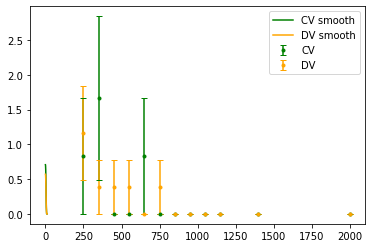

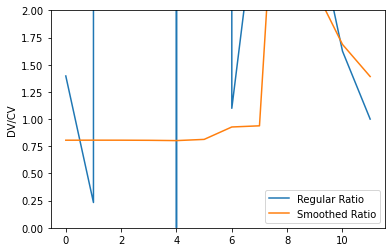

Enu_1e1p [3.77673474e-02 3.76273049e-02 3.77073125e-02 3.80976753e-02
 3.91672543e-02 3.49285272e-02 5.28291899e-03 3.83793593e-03
 1.65499195e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
Enu_1e1p [0.15713117 0.58869488 0.         0.         0.99999894 0.
 0.         0.         0.         0.         0.         0.        ]


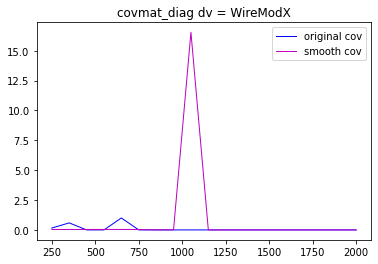

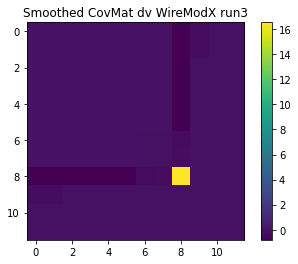

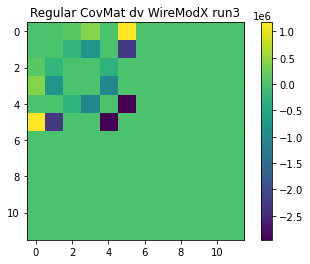

WireModYZ
nbin 12
12 2324
2324


/usr/lib/python3/dist-packages/ipykernel_launcher.py:79: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
/usr/lib/python3/dist-packages/ipykernel_launcher.py:114: DeprecationWarning: scipy.size is deprecated and will be removed in SciPy 2.0.0, use numpy.size instead


SAVING HERE 12
12 12


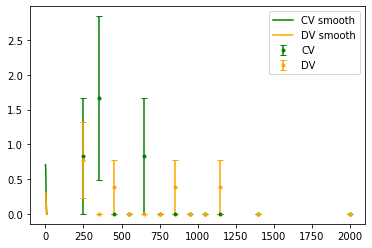

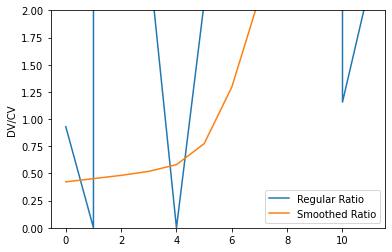

Enu_1e1p [3.33335473e-01 2.99864331e-01 2.68065295e-01 2.31105983e-01
 1.75801021e-01 5.12918609e-02 8.67298735e-02 1.25167416e+00
 5.20093566e+02 0.00000000e+00 0.00000000e+00 0.00000000e+00]
Enu_1e1p [0.00494896 0.99999111 0.         0.         0.9999988  0.
 0.         0.         0.         0.         0.         0.        ]


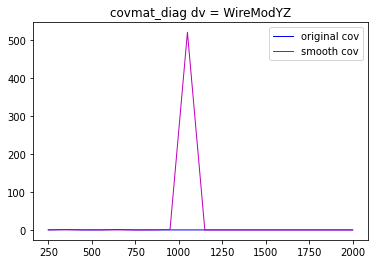

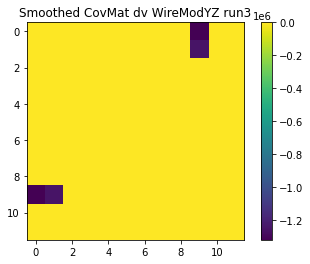

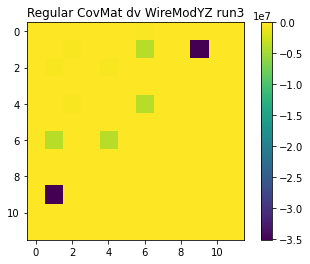

LYDown
nbin 12
12 2324
2324


/usr/lib/python3/dist-packages/ipykernel_launcher.py:79: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
/usr/lib/python3/dist-packages/ipykernel_launcher.py:114: DeprecationWarning: scipy.size is deprecated and will be removed in SciPy 2.0.0, use numpy.size instead


SAVING HERE 12
12 12


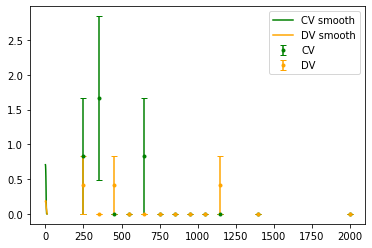

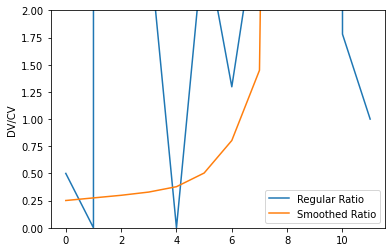

Enu_1e1p [5.60928384e-01 5.25618992e-01 4.91390876e-01 4.50596178e-01
 3.86843733e-01 2.46253447e-01 3.87761754e-02 2.01524256e-01
 3.57493615e+02 0.00000000e+00 0.00000000e+00 0.00000000e+00]
Enu_1e1p [0.24971813 0.99999201 0.         0.         0.99999896 0.
 0.         0.         0.         0.         0.         0.        ]


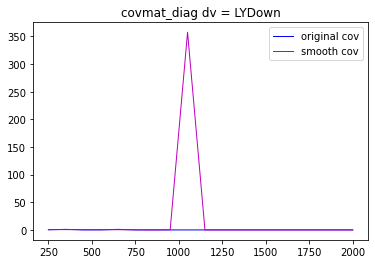

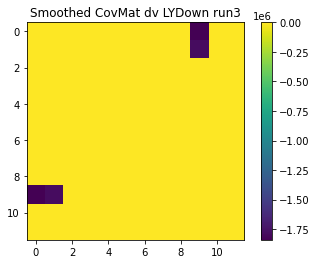

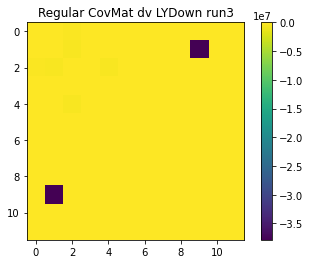

LYRayleigh
nbin 12
12 2324
2324


/usr/lib/python3/dist-packages/ipykernel_launcher.py:79: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
/usr/lib/python3/dist-packages/ipykernel_launcher.py:114: DeprecationWarning: scipy.size is deprecated and will be removed in SciPy 2.0.0, use numpy.size instead


SAVING HERE 12
12 12


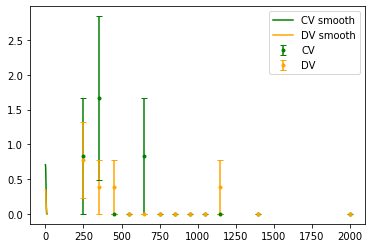

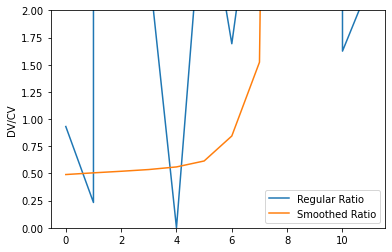

Enu_1e1p [2.60240330e-01 2.44484954e-01 2.30489034e-01 2.15377137e-01
 1.93661568e-01 1.48539573e-01 2.41998552e-02 2.73688818e-01
 3.97105385e+02 0.00000000e+00 0.00000000e+00 0.00000000e+00]
Enu_1e1p [0.00468592 0.58846271 0.         0.         0.99999911 0.
 0.         0.         0.         0.         0.         0.        ]


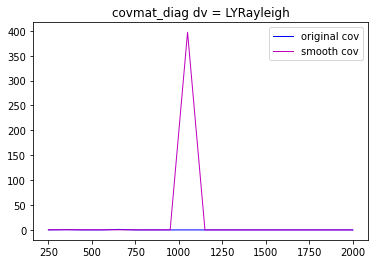

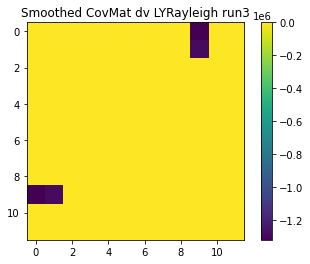

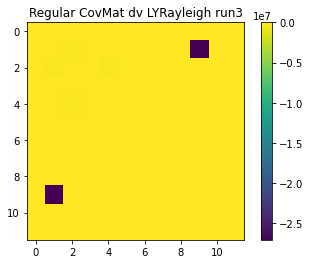

SCE
nbin 12
12 2324
2324
SAVING HERE 12


/usr/lib/python3/dist-packages/ipykernel_launcher.py:79: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
/usr/lib/python3/dist-packages/ipykernel_launcher.py:114: DeprecationWarning: scipy.size is deprecated and will be removed in SciPy 2.0.0, use numpy.size instead


12 12


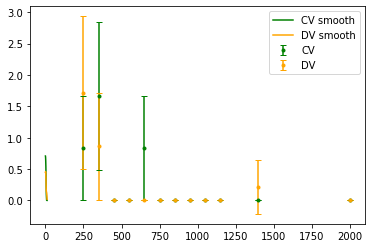

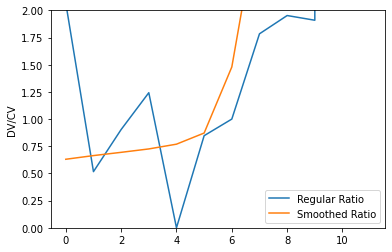

Enu_1e1p [1.36625563e-01 1.12743992e-01 9.35687422e-02 7.54037203e-02
 5.32714268e-02 1.64736977e-02 2.29599638e-01 3.71205041e+00
 1.74591315e+03 0.00000000e+00 0.00000000e+00 0.00000000e+00]
Enu_1e1p [1.13657596 0.23374301 0.         0.         0.99999942 0.
 0.         0.         0.         0.         0.         0.        ]


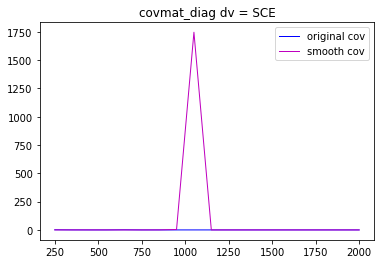

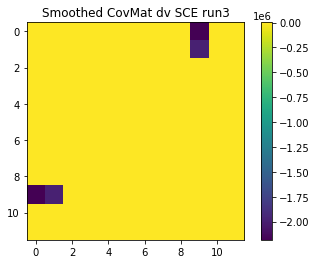

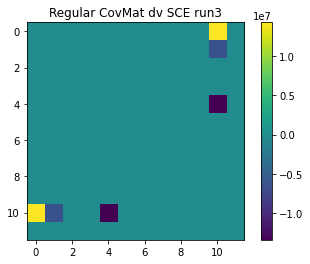

WireModThetaYZ
nbin 12
12 2324
2324


/usr/lib/python3/dist-packages/ipykernel_launcher.py:79: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
/usr/lib/python3/dist-packages/ipykernel_launcher.py:114: DeprecationWarning: scipy.size is deprecated and will be removed in SciPy 2.0.0, use numpy.size instead


SAVING HERE 12
12 12


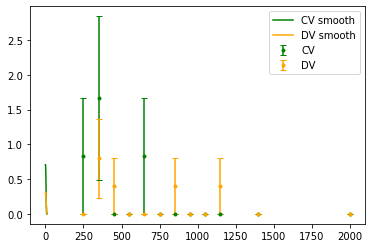

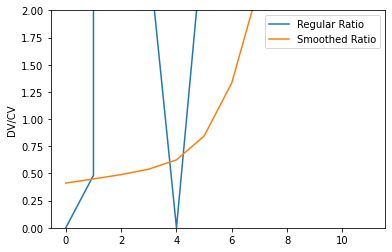

Enu_1e1p [3.46585689e-01 3.02811544e-01 2.60871209e-01 2.12021189e-01
 1.40736930e-01 2.42795910e-02 1.11355386e-01 1.53731232e+00
 6.60022448e+02 0.00000000e+00 0.00000000e+00 0.00000000e+00]
Enu_1e1p [0.99994661 0.26823724 0.         0.         0.99999894 0.
 0.         0.         0.         0.         0.         0.        ]


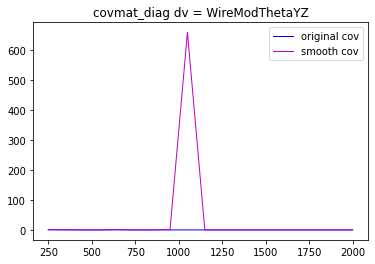

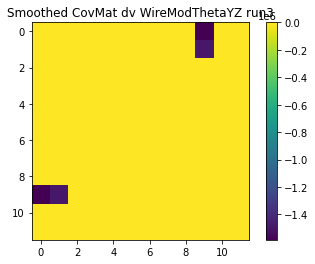

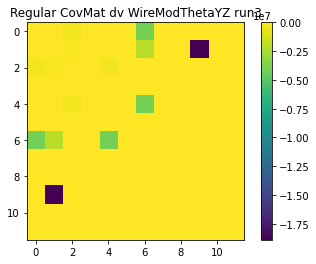

WireModThetaXZ
nbin 12
12 2324
2324


/usr/lib/python3/dist-packages/ipykernel_launcher.py:79: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
/usr/lib/python3/dist-packages/ipykernel_launcher.py:114: DeprecationWarning: scipy.size is deprecated and will be removed in SciPy 2.0.0, use numpy.size instead


SAVING HERE 12
12 12


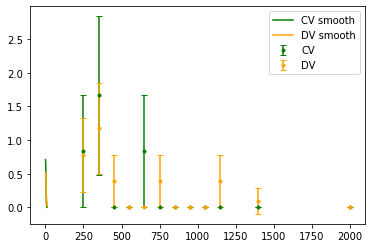

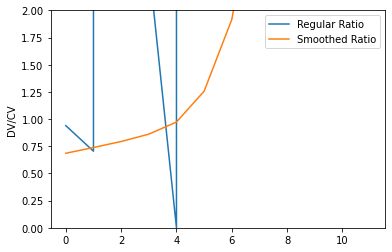

Enu_1e1p [9.89170955e-02 6.83070569e-02 4.25781307e-02 1.92269957e-02
 7.32328727e-04 6.58568908e-02 8.39757645e-01 5.52967351e+00
 1.74619831e+03 0.00000000e+00 0.00000000e+00 0.00000000e+00]
Enu_1e1p [0.00363848 0.08717135 0.         0.         0.99999875 0.
 0.         0.         0.         0.         0.         0.        ]


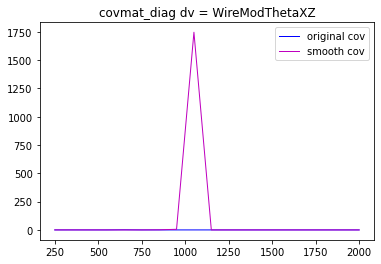

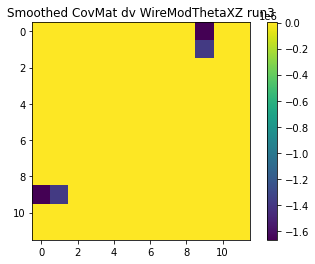

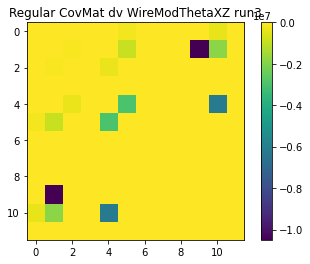

TOTAL DIAG: [ 1.33206602  1.26153009  1.19359566  1.11437376  0.9950951   0.7665661
  1.15572553  3.53691411 73.77924094  0.          0.          0.        ]


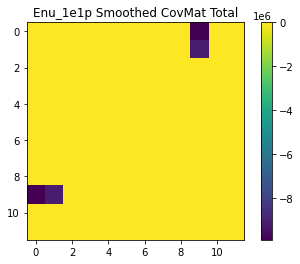

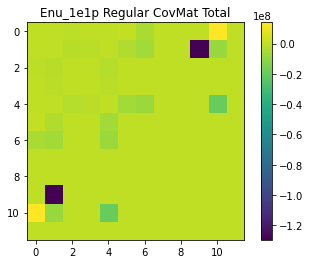

In [26]:
POT_SCALE = {}

POT_SCALE['run1'] = 1.746029e+20
POT_SCALE['run3'] = 2.6426e+20 + 2.429524e+20


cutMode=0

for mode in modelist: 
    plotfolder = basefolder+'PlotDumps/'+mode
    covfolder = basefolder+'covMatrix/'+mode
    histfolder = basefolder+'1Dhists/'+mode
    if not os.path.exists(plotfolder):
        os.makedirs(plotfolder)
    if not os.path.exists(covfolder):
        os.makedirs(covfolder)
    if not os.path.exists(histfolder):
        os.makedirs(histfolder)
    for sigcut in sigcutlist:
        key = tuple((sigcut,mode))
        plotfolder = basefolder+'PlotDumps/'+mode+'/BDTcut'+str(sigcut)
        covfolder = basefolder+'covMatrix/'+mode+'/BDTcut'+str(sigcut)
        histfolder = basefolder+'1Dhists/'+mode+'/BDTcut'+str(sigcut)
        if not os.path.exists(plotfolder):
            os.makedirs(plotfolder)
        if not os.path.exists(covfolder):
            os.makedirs(covfolder)
        if not os.path.exists(histfolder):
            os.makedirs(histfolder)
            

        run='run3'

        #for dist in varListSel: #[9:10]
        #for _,dist in varListSel.items(): # loop over all variables 
        for i in range(len(var_names)):
            varname = var_names[i]
            dist = varListSel[varname]
            if varname!='Enu_1e1p': continue
            #if varname not in ['EnuQE_lepton','EnuQE_proton','EnuTrue']: continue
            #if varname not in ['Eta','Enu_1e1p']: continue
            nbins = 12 
            cov = np.zeros((nbins,nbins))
            cov_smooth = np.zeros((nbins,nbins))


            for sysi in range(len(a_df_sys[key]['run3'])): # loop over all detvars
                name = names[key]['run3'][sysi]
                print(name)
                myvardf3 = a_df_sys[key]['run3'][name].query('Enu_1e1p > 0 and Enu_1e1p < 2400')
                POT3 = POT_SCALE['run3']
                if cutMode in [0,2] and name=='LYAtt': 
                    POT1 = 0
                myvardf = myvardf3


                var_sys = myvardf.query(s_cuts)[dist.myname]
                var_cv = myvardf.query(s_cuts_cv)[dist.myname]
                #print('cv = %d  and dv = %d'%(var_cv.shape[0],var_sys.shape[0]))

                pot_cv=myvardf.query("isCV==True").iloc[0]["POT"]
                pot_dv=myvardf.query("isCV==False").iloc[0]["POT"]
                #print("cv POT = %f dv POT = %f"%(pot_cv,pot_dv))


                # get cv and detvar lists and apply weights
                var_cv_list = np.array(var_cv.astype(float).values.tolist())
                var_sys_list = np.array(var_sys.astype(float).values.tolist())
                cv_weights = POT3 * np.array(myvardf3.query(s_cuts_cv)['bdtweight']) / np.array(myvardf3.query(s_cuts_cv)['POT'].astype(float).values.tolist())
                sys_weights = POT3 * np.array(myvardf3.query(s_cuts)['bdtweight']) / np.array(myvardf3.query(s_cuts)['POT'].astype(float).values.tolist())
                

                ratio = pot_cv / pot_dv
                cv_weights = np.where(np.logical_or(np.isnan(cv_weights),np.isinf(cv_weights)),0.0,cv_weights)
                sys_weights = np.where(np.logical_or(np.isnan(sys_weights),np.isinf(sys_weights)),0.0,sys_weights)

                vcl = var_cv_list[np.logical_not(np.logical_or(np.isnan(var_cv_list),np.isinf(var_cv_list)))]
                cw = cv_weights[np.logical_not(np.logical_or(np.isnan(var_cv_list),np.isinf(var_cv_list)))]

                vsl = var_sys_list[np.logical_not(np.logical_or(np.isnan(var_sys_list),np.isinf(var_sys_list)))]
                sw = sys_weights[np.logical_not(np.logical_or(np.isnan(var_sys_list),np.isinf(var_sys_list)))]


                CV_smooth,DV_smooth,hCV,h0,cverr,dverr = smooth(vcl,vsl,cw,sw,dist.myrange[0],dist.myrange[1],run,nbin=nbins)
                
                if True:
                    print("SAVING HERE", len(CV_smooth))
                    np.save(histfolder+'/1Dhist_%s_%s_%s_CV_smooth.npy'%(dist.myname, run, names[key]['run3'][sysi]),CV_smooth)
                    np.save(histfolder+'/1Dhist_%s_%s_%s_DV_smooth.npy'%(dist.myname, run, names[key]['run3'][sysi]),DV_smooth)
                    np.save(histfolder+'/1Dhist_%s_%s_%s_CV_reg.npy'%(dist.myname, run, names[key]['run3'][sysi]),hCV)
                    np.save(histfolder+'/1Dhist_%s_%s_%s_DV_reg.npy'%(dist.myname, run, names[key]['run3'][sysi]),h0)
    #                 print(hCV)
    #                 print(h0)
    #                 print(CV_smooth)
    #                 print(DV_smooth)

#                 binsE=[250,350,450,550,650,750,850,950,1050,1150,1250,1350,1450,1550,1650,1750,1850,1950,2050,2150,2250,2350]
                binsE=[250,350,450,550,650,750,850,950,1050,1150,1400,2000]
                print(len(binsE),len(hCV))
                plt.errorbar(binsE,hCV,cverr,label='CV',fmt='.',capsize=3,color='green')
                plt.errorbar(binsE,h0,dverr,label='DV',fmt='.',capsize=3,color='orange')
                plt.plot(CV_smooth,label='CV smooth',color='green')
                plt.plot(DV_smooth,label='DV smooth',color='orange')
                plt.legend()
                plt.savefig(plotfolder+'/detsys_%s_%s_%s_hists.png'%(dist.myname, run, name),dpi=120,bbox_inches='tight')
                plt.show()
                plt.plot(h0/hCV,label='Regular Ratio')
                plt.plot(DV_smooth/CV_smooth,label='Smoothed Ratio')
                plt.legend()
                plt.ylim(0,2)
                plt.ylabel('DV/CV')
                if verbose: plt.savefig(plotfolder+'/detsys_%s_%s_%s_ratio.png'%(dist.myname, run, name),dpi=120,bbox_inches='tight')
                plt.show()


        #        print(cv_weights)
            
                hCVq,binedges = np.histogram(vcl,bins=binsE,weights= cw)#cv_scale)
                h0q,_ = np.histogram(vsl,bins=binsE,weights=sw)#cv_scale)
                bincenters = np.diff(binedges)/2 + binedges[:-1] 
#                 h0q[-1]*= 1.0/8.0
#                 h0q[-2]*= 1.0/4.0
#                 hCVq[-1]*= 1.0/8.0
#                 hCVq[-2]*= 1.0/4.0
                cov_tmp = np.zeros((nbins,nbins))
                cov_smooth_tmp = np.zeros((nbins,nbins)) 
                
#                 print(h0,hCV)
                for i in range(nbins):
                    for j in range(nbins):
                        if (hCV[i]*hCV[j])<1e-8:
                            cov_tmp[i][j]=0
                        else:
            #               print('%d,%d'%(h0[i],hCV[j]))
                            cov_tmp[i][j] += (h0[i]-hCV[i])*(h0[j]-hCV[j])/(hCV[i]*hCV[j])
#                             print('result is: %d*%d/%d'%(h0[i]-hCV[i],h0[j]-hCV[j],hCV[i]*hCV[j]))
#                 print(dist.myname,cov_tmp.diagonal())

                for i in range(nbins):
                    for j in range(nbins):
                        if (CV_smooth[i]*CV_smooth[j])<1e-8:
                            cov_smooth_tmp[i][j]=0
                        else:
            #               print('%d,%d'%(h0[i],hCV[j]))
                            cov_smooth_tmp[i][j] += ((DV_smooth[i]-CV_smooth[i])*(DV_smooth[j]-CV_smooth[j]))/(CV_smooth[i]*CV_smooth[j])
#                             print(((DV_smooth[i]-CV_smooth[i])*(DV_smooth[j]-CV_smooth[j]))/(CV_smooth[i]*CV_smooth[j]))
                print(dist.myname,cov_smooth_tmp.diagonal())
                print(dist.myname,cov_tmp.diagonal())

                offset = (dist.myrange[1] - dist.myrange[0] )/(2*nbins)
                x= binsE
                if True:
                    plt.plot(x,cov_tmp.diagonal(),linewidth=1, linestyle="-", c="b",label='original cov')
                    plt.plot(x,cov_smooth_tmp.diagonal(),linewidth=1, linestyle="-", c="m",label='smooth cov')
                    plt.legend()
                    plt.title('covmat_diag dv = %s'%name)
                    plt.savefig(plotfolder+'/detsys_%s_%s_%s_cov_diag.png'%(dist.myname, run,name),dpi=120,bbox_inches='tight')

                    plt.show()

                    plt.imshow(cov_smooth_tmp, interpolation='none')
                    plt.colorbar(orientation='vertical')
                    plt.title('Smoothed CovMat dv %s %s'%(name,run))

                    plt.savefig(plotfolder+'/detsys_%s_%s_%s_cov.png'%(dist.myname, run,name),dpi=120,bbox_inches='tight')
                    plt.show()

                    plt.imshow(cov_tmp, interpolation='none')
                    plt.colorbar(orientation='vertical')
                    plt.title('Regular CovMat dv %s %s'%(name,run))

                    plt.savefig(plotfolder+'/detsys_%s_%s_%s_cov_reg.png'%(dist.myname, run,name),dpi=120,bbox_inches='tight')
                    plt.show()

                    cov = cov+ cov_tmp
                    cov_smooth += cov_smooth_tmp
#                 plt.imshow(cov_smooth_tmp, interpolation='none')
#                 plt.colorbar(orientation='vertical')
#                 plt.title(varname+' Regular CovMat Total')
#                 plt.show()

                #plt.plot(np.sqrt(np.diag(cov_smooth_tmp)),label=name)
                
            #plt.legend()
            #plt.title('Diagonals: '+str(dist.myname))
            #plt.show()
            print('TOTAL DIAG:',np.sqrt(np.diag(cov_smooth)))
            plt.imshow(cov_smooth, interpolation='none')
            plt.colorbar(orientation='vertical')
            plt.title(varname+' Smoothed CovMat Total')

            plt.savefig(plotfolder+'/detsys_%s_%s_cutMode%s_cov_smooth.png'%(dist.myname, run, str(cutMode)),dpi=120,bbox_inches='tight')

            plt.show()

            plt.imshow(cov, interpolation='none')
            plt.colorbar(orientation='vertical')
            plt.title(varname+' Regular CovMat Total')

            plt.savefig(plotfolder+'/detsys_%s_%s_cutMode%s_cov_reg.png'%(dist.myname, run, str(cutMode)),dpi=120,bbox_inches='tight')

            plt.show()
            
            if verbose:
                plt.plot(x,cov.diagonal(),linewidth=1, linestyle="-", c="b",label='original cov')
                plt.plot(x,cov_smooth.diagonal(),linewidth=1, linestyle="-", c="m",label='smooth cov')
                plt.legend()
                plt.title('Total covmat_diag dv = %s'%name)
                plt.show()


            np.savetxt(covfolder+'/detsys_%s_%s_cutMode%s_cov_smooth.csv'%(dist.myname, run, str(cutMode)),cov_smooth, delimiter=',')
            np.savetxt(covfolder+'/detsys_%s_%s_cutMode%s_cov_reg.csv'%(dist.myname, run, str(cutMode)),cov, delimiter=',')


# Run 1

WireModX
nbin 12
12 2324
2324


/usr/lib/python3/dist-packages/ipykernel_launcher.py:79: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
/usr/lib/python3/dist-packages/ipykernel_launcher.py:114: DeprecationWarning: scipy.size is deprecated and will be removed in SciPy 2.0.0, use numpy.size instead


12 12


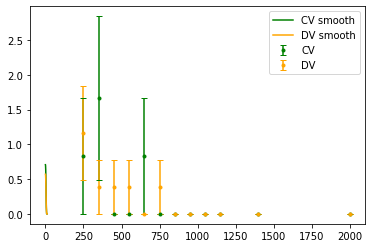

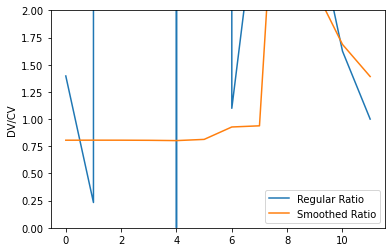

Enu_1e1p [3.77673474e-02 3.76273049e-02 3.77073125e-02 3.80976753e-02
 3.91672543e-02 3.49285272e-02 5.28291899e-03 3.83793593e-03
 1.65499195e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
Enu_1e1p [0.15713117 0.58869488 0.         0.         0.99999894 0.
 0.         0.         0.         0.         0.         0.        ]


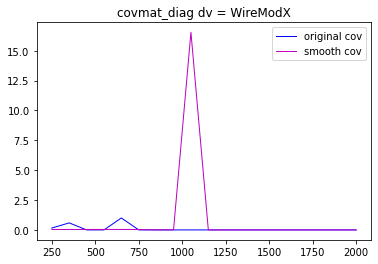

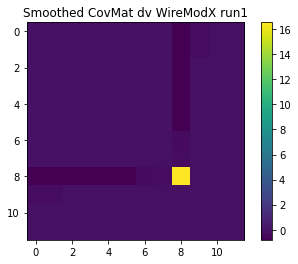

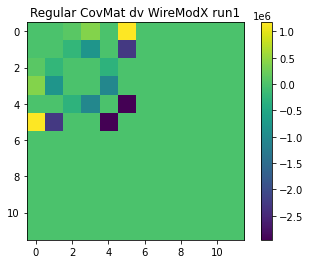

WireModYZ
nbin 12
12 2324
2324


/usr/lib/python3/dist-packages/ipykernel_launcher.py:79: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
/usr/lib/python3/dist-packages/ipykernel_launcher.py:114: DeprecationWarning: scipy.size is deprecated and will be removed in SciPy 2.0.0, use numpy.size instead


12 12


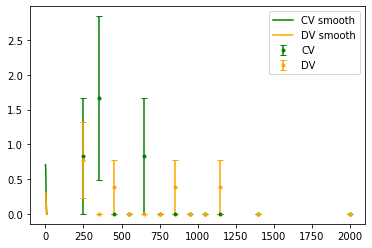

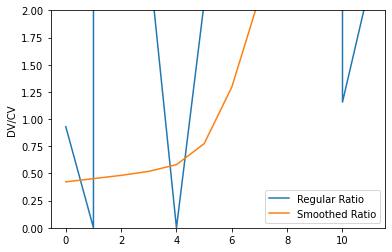

Enu_1e1p [3.33335473e-01 2.99864331e-01 2.68065295e-01 2.31105983e-01
 1.75801021e-01 5.12918609e-02 8.67298735e-02 1.25167416e+00
 5.20093566e+02 0.00000000e+00 0.00000000e+00 0.00000000e+00]
Enu_1e1p [0.00494896 0.99999111 0.         0.         0.9999988  0.
 0.         0.         0.         0.         0.         0.        ]


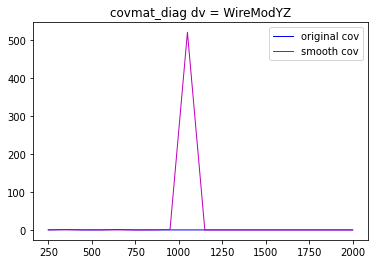

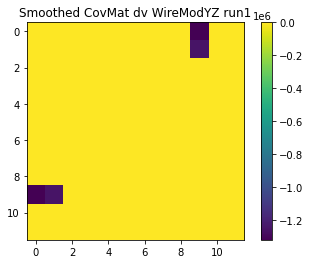

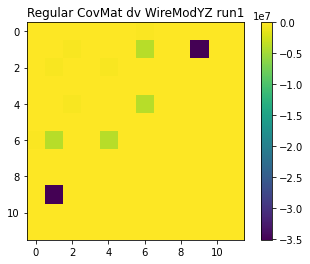

LYDown
nbin 12
12 2256
2256


/usr/lib/python3/dist-packages/ipykernel_launcher.py:79: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
/usr/lib/python3/dist-packages/ipykernel_launcher.py:114: DeprecationWarning: scipy.size is deprecated and will be removed in SciPy 2.0.0, use numpy.size instead


12 12


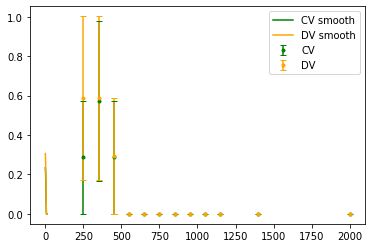

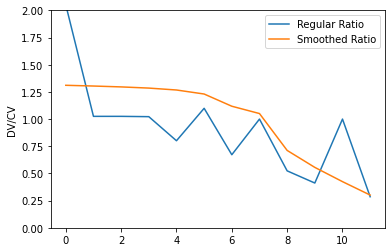

Enu_1e1p [0.09659635 0.09239579 0.08757769 0.08125606 0.07156074 0.05313498
 0.01397724 0.00259023 0.         0.         0.         0.        ]
Enu_1e1p [1.10276964e+00 6.29146190e-04 6.29161251e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]


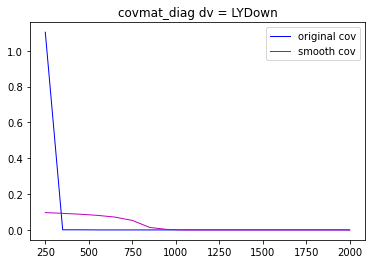

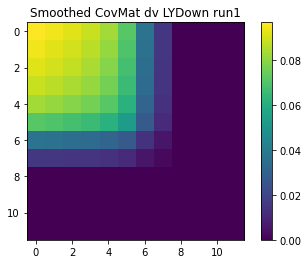

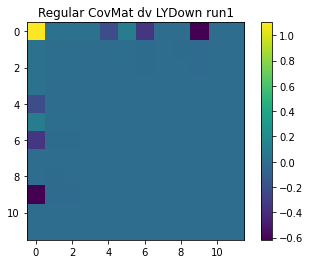

LYRayleigh
nbin 12
12 2256
2256


/usr/lib/python3/dist-packages/ipykernel_launcher.py:79: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
/usr/lib/python3/dist-packages/ipykernel_launcher.py:114: DeprecationWarning: scipy.size is deprecated and will be removed in SciPy 2.0.0, use numpy.size instead


IndexError: list index out of range

In [28]:
for mode in modelist: 
    plotfolder = basefolder+'PlotDumps/'+mode
    covfolder = basefolder+'covMatrix/'+mode
    histfolder = basefolder+'1Dhists/'+mode
    if not os.path.exists(plotfolder):
        os.makedirs(plotfolder)
    if not os.path.exists(covfolder):
        os.makedirs(covfolder)
    if not os.path.exists(histfolder):
        os.makedirs(histfolder)
    for sigcut in sigcutlist:
        key = tuple((sigcut,mode))
        plotfolder = basefolder+'PlotDumps/'+mode+'/BDTcut'+str(sigcut)
        covfolder = basefolder+'covMatrix/'+mode+'/BDTcut'+str(sigcut)
        histfolder = basefolder+'1Dhists/'+mode+'/BDTcut'+str(sigcut)
        if not os.path.exists(plotfolder):
            os.makedirs(plotfolder)
        if not os.path.exists(covfolder):
            os.makedirs(covfolder)
        if not os.path.exists(histfolder):
            os.makedirs(histfolder)
  

        run='run1'

        #for dist in varListSel: #[9:10]
        #for _,dist in varListSel.items(): # loop over all variables 
        for i in range(len(var_names)):
            varname = var_names[i]
            dist = varListSel[varname]
            if varname!='Enu_1e1p': continue
            nbins = 12 

            cov = np.zeros((nbins,nbins))
            cov_smooth = np.zeros((nbins,nbins))


            for sysi in range(len(a_df_sys[key]['run3'])): # loop over all detvars
        #    for sysi in range(1):
        #        sysi = 3
        #        myvardf = a_df_sys[sysi].query('Enu_1m1p > 0 and Enu_1m1p_cv > 0')
                name = names[key]['run3'][sysi]
                print(name)
                try: 
                    myvardf1 = a_df_sys[key]['run1'][name].query('Enu_1e1p > 0 and Enu_1e1p < 2400')
                    POT1 = POT_SCALE['run1']
                except:
                    myvardf1 = a_df_sys[key]['run3'][name].query('Enu_1e1p > 0 and Enu_1e1p < 2400')
                    POT1 = POT_SCALE['run3']
                if cutMode in [0,2] and name=='LYAtt': 
                    POT1 = 0
                myvardf =myvardf1
                #print(a_df_sys[run][sysi].query("isCV==True")[['POT','Etrue']])
                #print(a_df_sys[run][sysi].query("isCV==False")[['POT','Etrue']])

                var_sys = myvardf.query(s_cuts)[dist.myname]
                var_cv = myvardf.query(s_cuts_cv)[dist.myname]
                #print('cv = %d  and dv = %d'%(var_cv.shape[0],var_sys.shape[0]))

                pot_cv=myvardf.query("isCV==True").iloc[0]["POT"]
                pot_dv=myvardf.query("isCV==False").iloc[0]["POT"]
                #print("cv POT = %f dv POT = %f"%(pot_cv,pot_dv))


                # get cv and detvar lists and apply weights
                var_cv_list = np.array(var_cv.astype(float).values.tolist())
                var_sys_list = np.array(var_sys.astype(float).values.tolist())
                cv_weights = POT1 * np.array(myvardf1.query(s_cuts_cv)['bdtweight']) / np.array(myvardf1.query(s_cuts_cv)['POT'].astype(float).values.tolist())
                sys_weights = POT1 * np.array(myvardf1.query(s_cuts)['bdtweight']) / np.array(myvardf1.query(s_cuts)['POT'].astype(float).values.tolist())
                
                ratio = pot_cv / pot_dv
                cv_weights = np.where(np.logical_or(np.isnan(cv_weights),np.isinf(cv_weights)),0.0,cv_weights)
                sys_weights = np.where(np.logical_or(np.isnan(sys_weights),np.isinf(sys_weights)),0.0,sys_weights)

                vcl = var_cv_list[np.logical_not(np.logical_or(np.isnan(var_cv_list),np.isinf(var_cv_list)))]
                cw = cv_weights[np.logical_not(np.logical_or(np.isnan(var_cv_list),np.isinf(var_cv_list)))]

                vsl = var_sys_list[np.logical_not(np.logical_or(np.isnan(var_sys_list),np.isinf(var_sys_list)))]
                sw = sys_weights[np.logical_not(np.logical_or(np.isnan(var_sys_list),np.isinf(var_sys_list)))]

                #var_cv_list = var_cv_list * cv_weights 

                #var_sys_list = var_sys_list * sys_weights 




                CV_smooth,DV_smooth,hCV,h0,cverr,dverr = smooth(vcl,vsl,cw,sw,dist.myrange[0],dist.myrange[1],run,nbin=nbins)
                
                if True:
                    np.save(histfolder+'/1Dhist_%s_%s_%s_CV_smooth.npy'%(dist.myname, run, names[key]['run1'][sysi]),CV_smooth)
                    np.save(histfolder+'/1Dhist_%s_%s_%s_DV_smooth.npy'%(dist.myname, run, names[key]['run1'][sysi]),DV_smooth)
                    np.save(histfolder+'/1Dhist_%s_%s_%s_CV_reg.npy'%(dist.myname, run, names[key]['run1'][sysi]),hCV)
                    np.save(histfolder+'/1Dhist_%s_%s_%s_DV_reg.npy'%(dist.myname, run, names[key]['run1'][sysi]),h0)
    #                 print(hCV)
    #                 print(h0)
    #                 print(CV_smooth)
    #                 print(DV_smooth)

#                 binsE=[250,350,450,550,650,750,850,950,1050,1150,1250,1350,1450,1550,1650,1750,1850,1950,2050,2150,2250,2350]
                binsE=[250,350,450,550,650,750,850,950,1050,1150,1400,2000]
                print(len(binsE),len(hCV))
                plt.errorbar(binsE,hCV,cverr,label='CV',fmt='.',capsize=3,color='green')
                plt.errorbar(binsE,h0,dverr,label='DV',fmt='.',capsize=3,color='orange')
                plt.plot(CV_smooth,label='CV smooth',color='green')
                plt.plot(DV_smooth,label='DV smooth',color='orange')
                plt.legend()
                plt.savefig(plotfolder+'/detsys_%s_%s_%s_hists.png'%(dist.myname, run, name),dpi=120,bbox_inches='tight')
                plt.show()
                plt.plot(h0/hCV,label='Regular Ratio')
                plt.plot(DV_smooth/CV_smooth,label='Smoothed Ratio')
                plt.legend()
                plt.ylim(0,2)
                plt.ylabel('DV/CV')
                if verbose: plt.savefig(plotfolder+'/detsys_%s_%s_%s_ratio.png'%(dist.myname, run, name),dpi=120,bbox_inches='tight')
                plt.show()


        #        print(cv_weights)
            
                hCVq,binedges = np.histogram(vcl,bins=binsE,weights= cw)#cv_scale)
                h0q,_ = np.histogram(vsl,bins=binsE,weights=sw)#cv_scale)
                bincenters = np.diff(binedges)/2 + binedges[:-1] 
#                 h0q[-1]*= 1.0/8.0
#                 h0q[-2]*= 1.0/4.0
#                 hCVq[-1]*= 1.0/8.0
#                 hCVq[-2]*= 1.0/4.0
                cov_tmp = np.zeros((nbins,nbins))
                cov_smooth_tmp = np.zeros((nbins,nbins)) 
                
#                 print(h0,hCV)
                for i in range(nbins):
                    for j in range(nbins):
                        if (hCV[i]*hCV[j])<1e-8:
                            cov_tmp[i][j]=0
                        else:
            #               print('%d,%d'%(h0[i],hCV[j]))
                            cov_tmp[i][j] += (h0[i]-hCV[i])*(h0[j]-hCV[j])/(hCV[i]*hCV[j])
#                             print('result is: %d*%d/%d'%(h0[i]-hCV[i],h0[j]-hCV[j],hCV[i]*hCV[j]))
#                 print(dist.myname,cov_tmp.diagonal())

                for i in range(nbins):
                    for j in range(nbins):
                        if (CV_smooth[i]*CV_smooth[j])<1e-8:
                            cov_smooth_tmp[i][j]=0
                        else:
            #               print('%d,%d'%(h0[i],hCV[j]))
                            cov_smooth_tmp[i][j] += ((DV_smooth[i]-CV_smooth[i])*(DV_smooth[j]-CV_smooth[j]))/(CV_smooth[i]*CV_smooth[j])
#                             print(((DV_smooth[i]-CV_smooth[i])*(DV_smooth[j]-CV_smooth[j]))/(CV_smooth[i]*CV_smooth[j]))
                print(dist.myname,cov_smooth_tmp.diagonal())
                print(dist.myname,cov_tmp.diagonal())

                offset = (dist.myrange[1] - dist.myrange[0] )/(2*nbins)
                x= binsE
                if True:
                    plt.plot(x,cov_tmp.diagonal(),linewidth=1, linestyle="-", c="b",label='original cov')
                    plt.plot(x,cov_smooth_tmp.diagonal(),linewidth=1, linestyle="-", c="m",label='smooth cov')
                    plt.legend()
                    plt.title('covmat_diag dv = %s'%name)
                    plt.savefig(plotfolder+'/detsys_%s_%s_%s_cov_diag.png'%(dist.myname, run,name),dpi=120,bbox_inches='tight')

                    plt.show()

                    plt.imshow(cov_smooth_tmp, interpolation='none')
                    plt.colorbar(orientation='vertical')
                    plt.title('Smoothed CovMat dv %s %s'%(name,run))

                    plt.savefig(plotfolder+'/detsys_%s_%s_%s_cov.png'%(dist.myname, run,name),dpi=120,bbox_inches='tight')
                    plt.show()

                    plt.imshow(cov_tmp, interpolation='none')
                    plt.colorbar(orientation='vertical')
                    plt.title('Regular CovMat dv %s %s'%(name,run))

                    plt.savefig(plotfolder+'/detsys_%s_%s_%s_cov_reg.png'%(dist.myname, run,name),dpi=120,bbox_inches='tight')
                    plt.show()

                    cov = cov+ cov_tmp
                    cov_smooth += cov_smooth_tmp
#                 plt.imshow(cov_smooth_tmp, interpolation='none')
#                 plt.colorbar(orientation='vertical')
#                 plt.title(varname+' Regular CovMat Total')
#                 plt.show()

                #plt.plot(np.sqrt(np.diag(cov_smooth_tmp)),label=name)
                
            #plt.legend()
            #plt.title('Diagonals: '+str(dist.myname))
            #plt.show()
            print('TOTAL DIAG:',np.sqrt(np.diag(cov_smooth)))
            plt.imshow(cov_smooth, interpolation='none')
            plt.colorbar(orientation='vertical')
            plt.title(varname+' Smoothed CovMat Total')

            plt.savefig(plotfolder+'/detsys_%s_%s_cutMode%s_cov_smooth.png'%(dist.myname, run, str(cutMode)),dpi=120,bbox_inches='tight')

            plt.show()

            plt.imshow(cov, interpolation='none')
            plt.colorbar(orientation='vertical')
            plt.title(varname+' Regular CovMat Total')

            plt.savefig(plotfolder+'/detsys_%s_%s_cutMode%s_cov_reg.png'%(dist.myname, run, str(cutMode)),dpi=120,bbox_inches='tight')

            plt.show()
            
            if verbose:
                plt.plot(x,cov.diagonal(),linewidth=1, linestyle="-", c="b",label='original cov')
                plt.plot(x,cov_smooth.diagonal(),linewidth=1, linestyle="-", c="m",label='smooth cov')
                plt.legend()
                plt.title('Total covmat_diag dv = %s'%name)
                plt.show()


            np.savetxt(covfolder+'/detsys_%s_%s_cutMode%s_cov_smooth.csv'%(dist.myname, run, str(cutMode)),cov_smooth, delimiter=',')
            np.savetxt(covfolder+'/detsys_%s_%s_cutMode%s_cov_reg.csv'%(dist.myname, run, str(cutMode)),cov, delimiter=',')
